In [41]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.core import *
from fastai.io import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.learner import *
import os
from audio_dataset import *

import IPython.display as ipd

In [39]:
import librosa
from librosa import display

## Load Data

In [3]:
PATH = Path('data/freesound')
TRN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

In [4]:
list(PATH.iterdir())

[PosixPath('data/freesound/sample_submission.csv'),
 PosixPath('data/freesound/models'),
 PosixPath('data/freesound/train.csv'),
 PosixPath('data/freesound/audio_train'),
 PosixPath('data/freesound/audio_test'),
 PosixPath('data/freesound/tmp')]

In [5]:
trn = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'sample_submission.csv')

In [6]:
trn.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [7]:
trn.shape[0], len(trn.label.unique())

(9473, 41)

In [8]:
fnames = list(trn['fname']) 
len(fnames), fnames[:5]

(9473,
 ['00044347.wav',
  '001ca53d.wav',
  '002d256b.wav',
  '0033e230.wav',
  '00353774.wav'])

In [9]:
trn_wavs = (PATH/'audio_train').glob('*.wav')
test_wavs = (PATH/'audio_test').glob('*.wav')

In [10]:
aud = get_audio(next(trn_wavs)); aud.shape

(1, 132300)

### Distribution of Categories

In [ ]:
cat_grp = trn.groupby(['label', 'manually_verified']).count()
plot = cat_grp.unstack().reindex(cat_grp.unstack().sum(axis=1).sort_values().index).plot(
    kind='bar', stacked=True, title='Number of Audio Samples per Category', figsize=(16,10))
plot.set_xlabel('Category')
plot.set_ylabel('Number of Samples');

Fairly small percentage of "manually verified" sound clips.

In [ ]:
print('Minimum samples in a category:', min(trn.label.value_counts()))
print('Maximum samples in a category:', max(trn.label.value_counts()))

In [ ]:
import wave

f = str(PATH/'audio_train/001ca53d.wav')
wav = wave.open(f)
print('Sampling (frame) rate:', wav.getframerate())
print('Total samples (frames):', wav.getnframes())
print('Duration:', wav.getnframes()/wav.getframerate())

In [ ]:
#import torchaudio -- torchaudio not available in Fastai environment
# using scipy
from scipy.io import wavfile
rate, data = wavfile.read(f)
print('Sampling (frame) rate:', rate)
print('Total samples (frames):', data.shape)
print(data)

Plot audio frames

In [ ]:
plt.plot(data, '-', );

Zoom in to view 250 frames

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(data[25250:25500], '.'); plt.plot(data[25250:25500], '-');

In [ ]:
trn['nframes'] = trn['fname'].apply(lambda f: wave.open('data/freesound/audio_train/'+f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('data/freesound/audio_test/'+f).getnframes())

_,ax = plt.subplots(figsize=(16,4))
sns.violinplot(ax=ax, x='label', y='nframes', data=trn)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
trn.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle("Frame Length Distribution in Train and Test", ha='center', fontsize='large');

1. The majority of frame lengths are short.
2. There are 4 abnormal lengths in test set. Let's analyze them.

### Listen to Sounds

In [11]:
l=3*44100 #seconds * sample_rate

#play sample with stats
length = 3*44100
sample = next(trn_wavs)
raw = open_audio(sample)
raw_len = len(raw[0,:])
raw = raw[0,:length]
if raw_len < length:
    raw = np.pad(raw, ((length-raw_len)//2), 'constant')
raw_max = np.argmax(raw)
print('raw_max:', raw_max)
start = max(0, (raw_max-(length//2)))
if start == 0:
    end = start+length
end = raw_max+(length//2)
if start+end > length:
    start = 0
    end = length
print('start:', start, 'end:', end)
raw_s = raw[start:end]
#pdb.set_trace()
print('raw length: ', raw_len, 'sample length:', len(raw_s))
s_label = str(sample).split('/')[-1]
print(trn[['label', 'manually_verified']].iloc[fnames.index(s_label)])
ipd.Audio(raw_s, rate=44100)

raw_max: 63103
start: 0 end: 129253
raw length:  132300 sample length: 129253
label                Cough
manually_verified        0
Name: 4060, dtype: object


## Model

In [12]:
classes = trn.label.unique(); classes

array(['Hi-hat', 'Saxophone', 'Trumpet', 'Glockenspiel', 'Cello', 'Knock', 'Gunshot_or_gunfire', 'Clarinet',
       'Computer_keyboard', 'Keys_jangling', 'Snare_drum', 'Writing', 'Laughter', 'Tearing', 'Fart', 'Oboe',
       'Flute', 'Cough', 'Telephone', 'Bark', 'Chime', 'Bass_drum', 'Bus', 'Squeak', 'Scissors', 'Harmonica',
       'Gong', 'Microwave_oven', 'Burping_or_eructation', 'Double_bass', 'Shatter', 'Fireworks', 'Tambourine',
       'Cowbell', 'Electric_piano', 'Meow', 'Drawer_open_or_close', 'Applause', 'Acoustic_guitar',
       'Violin_or_fiddle', 'Finger_snapping'], dtype=object)

In [13]:
def preprocess_ys(labels, one_hot=False):
    if isinstance(labels[0], str):
        tok2int = {v:k for k,v in enumerate(np.unique(labels))}
        labels = np.array([tok2int[tok] for tok in labels])
    num_classes = len(np.unique(labels))
    if one_hot:
        return [one_hot(labels[i], num_classes).reshape(1, num_classes) for i in range(len(labels))]
    else:
        return labels

In [14]:
labels = list(trn['label'])
labels = preprocess_ys(labels)
labels[:5]

array([23, 30, 38, 19,  6])

## Simplenet

### ImageClassifier Data Method

In [ ]:
stats = (np.array([-39.29504]), np.array([14.3013]))

In [ ]:
sz=128
# TODO: convert for audio
tfms = tfms_from_stats(stats, sz, aug_tfms=None, pad=sz//8)
data = ImageClassifierData.from_names_and_array(TRN_PATH, fnames, y, classes, val_idxs=idxs, bs=4, tfms=tfms)



### ConvNet

In [27]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv1d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [43]:
#tfms = get_audio(TRN_PATH, melspect=True)
md = AudioClassifierData.from_names_and_array(TRN_PATH, fnames, labels, classes, val_idxs=None, bs=64) #tfms=(tfms,tfms)

In [44]:
learn = ConvLearner.from_model_data(ConvNet([1, 16, 32, 64], 41), md)

In [45]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                   
    0      3.871796   7.385333   0.036431  



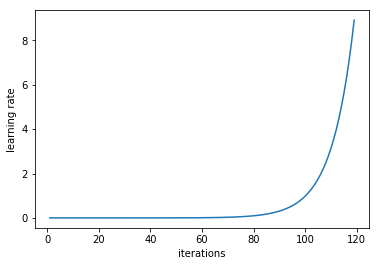

In [46]:
learn.sched.plot_lr()

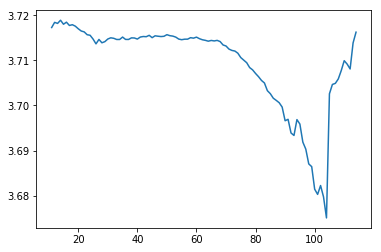

In [47]:
learn.sched.plot_loss()

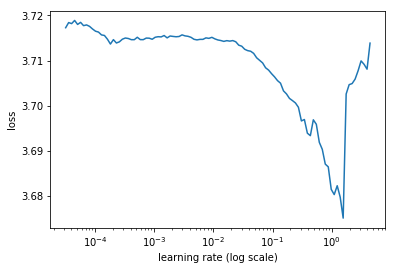

In [48]:
learn.sched.plot()

In [31]:
learn.fit(1e-1,3,cycle_len=2,wds=1e-5, use_clr_beta=(5, 20, 0.95, 0.75), metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      3.580708   3.52308    0.06019   
    1      3.389112   3.359034   0.101373                   
    2      3.228451   3.234034   0.12038                    
    3      3.094029   3.069082   0.181626                   
    4      3.02633    3.112131   0.171067                   
    5      2.918608   2.957004   0.192186                   



[array([ 2.957]), 0.19218585006853342]

In [32]:
learn.save('1d_convnet_1')

In [33]:
learn.fit(1e-1, 5, cycle_len=5, use_clr_beta=(5,20,0.95,0.75), metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                   
    0      2.920114   2.980003   0.205385  
    1      2.844616   2.980142   0.200106                   
    2      2.825885   2.918399   0.217001                   
    3      2.760741   2.801805   0.231785                   
    4      2.660617   2.68109    0.280359                   
    5      2.663216   2.793868   0.277191                   
    6      2.636351   2.701043   0.267159                   
    7      2.605775   2.792782   0.250792                   
    8      2.562335   2.71104    0.290391                   
    9      2.435571   2.566141   0.313622                   
    10     2.545189   2.682595   0.271383                   
    11     2.520481   2.678483   0.290391                   
    12     2.495054   2.592337   0.306758                   
    13     2.42926    2.687376   0.288279                   
    14     2.332967   2.511428   0.337381                   
    15     2.438655   2.626647   0.288807

[array([ 2.41749]), 0.34846884910697795]

In [34]:
learn.save('1d_convnet_2')